In [31]:
import pandas as pd

# STEP 1: Load both CSVs (make sure they're in your working directory)
user_txns = pd.read_csv("User Transactions.csv")
user_demo = pd.read_csv("User Dempgraphics.csv")


In [33]:
print("Transaction columns:", user_txns.columns)
purchase_col = [col for col in user_txns.columns if "Purchase Value" in col][0]


Transaction columns: Index(['User ID', 'Order ID', 'order Date', ' Order Purchase Value '], dtype='object')


In [35]:
# STEP 2: Clean 'Order Purchase Value' column
user_txns['Order Purchase Value'] = (
    user_txns[' Order Purchase Value ']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
    .astype(float)
)

# Drop the original column with spaces
user_txns.drop(columns=[' Order Purchase Value '], inplace=True)

# ✅ Confirm it worked
print(user_txns[['Order Purchase Value']].head())

   Order Purchase Value
0                  5.40
1                 39.50
2                 73.73
3                 16.23
4                 10.96


In [39]:
# STEP 3: Convert date columns with explicit format
user_txns['order Date'] = pd.to_datetime(user_txns['order Date'], format="%d-%m-%y")
user_demo['Birth Date'] = pd.to_datetime(user_demo['Birth Date'], format="%d-%m-%y")
user_demo['Signup Date'] = pd.to_datetime(user_demo['Signup Date'], format="%d-%m-%y")

In [41]:
# STEP 4: Calculate Age
today = pd.Timestamp.today()
user_demo['Age'] = (today - user_demo['Birth Date']).dt.days // 365

In [43]:
# STEP 5: Merge on 'User ID'
df = pd.merge(user_txns, user_demo, on='User ID', how='inner')


In [45]:
# STEP 6: Filter users with missing Gender or Age
df = df.dropna(subset=['Gender', 'Age'])

In [47]:
# STEP 7: Final preview
print("✅ Final cleaned & merged dataset shape:", df.shape)
display(df.head())

✅ Final cleaned & merged dataset shape: (8171, 9)


,User ID,Order ID,order Date,Order Purchase Value,Birth Date,Gender,Signup Date,State,Age
0,7,199785,2024-12-28,5.40,2039-12-14,Male,2018-12-14,Baghdad,-15.0
1,10,133690,2024-02-19,39.50,1992-09-09,Female,2018-12-17,Baghdad,32.0
2,25,159020,2024-07-23,73.73,1995-01-12,Male,2018-12-27,Baghdad,30.0
3,25,161151,2024-08-02,16.23,1995-01-12,Male,2018-12-27,Baghdad,30.0
4,52,183857,2024-11-13,10.96,1989-01-11,Female,2019-01-08,Baghdad,36.0


In [49]:
user_summary = df.groupby('User ID').agg({
    'Order ID': 'nunique',                          # Total orders
    'Order Purchase Value': ['sum', 'mean'],        # Total spend, Avg order
    'order Date': ['min', 'max', 'nunique'],        # First, last order, frequency
    'Gender': 'first',
    'Age': 'first',
    'State': 'first',
    'Signup Date': 'first'
})

# Flatten column names
user_summary.columns = ['_'.join(col).strip() for col in user_summary.columns.values]
user_summary = user_summary.reset_index()

# Rename for clarity
user_summary.rename(columns={
    'Order ID_nunique': 'Total_Orders',
    'Order Purchase Value_sum': 'Total_Spend',
    'Order Purchase Value_mean': 'Avg_Order_Value',
    'order Date_min': 'First_Order_Date',
    'order Date_max': 'Last_Order_Date',
    'order Date_nunique': 'Active_Days'
}, inplace=True)

# Preview
display(user_summary.head())

,User ID,Total_Orders,Total_Spend,Avg_Order_Value,First_Order_Date,Last_Order_Date,Active_Days,Gender_first,Age_first,State_first,Signup Date_first
0,7,1,5.40,5.40,2024-12-28,2024-12-28,1,Male,-15.0,Baghdad,2018-12-14
1,10,1,39.50,39.50,2024-02-19,2024-02-19,1,Female,32.0,Baghdad,2018-12-17
2,25,2,89.96,44.98,2024-07-23,2024-08-02,2,Male,30.0,Baghdad,2018-12-27
3,52,1,10.96,10.96,2024-11-13,2024-11-13,1,Female,36.0,Baghdad,2019-01-08
4,108,1,94.60,94.60,2024-08-25,2024-08-25,1,Male,31.0,Baghdad,2019-02-09


In [55]:
# Recency in days (from today)
user_summary['Recency_Days'] = (pd.Timestamp.today() - user_summary['Last_Order_Date']).dt.days

# Tenure
user_summary['Tenure_Days'] = (user_summary['Last_Order_Date'] - user_summary['First_Order_Date']).dt.days

# Orders per active day
user_summary['Orders_Per_Day'] = user_summary['Total_Orders'] / (user_summary['Tenure_Days'] + 1)


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['Total_Spend', 'Avg_Order_Value', 'Recency_Days', 'Orders_Per_Day']
X = user_summary[features]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
user_summary['Segment'] = kmeans.fit_predict(X_scaled)

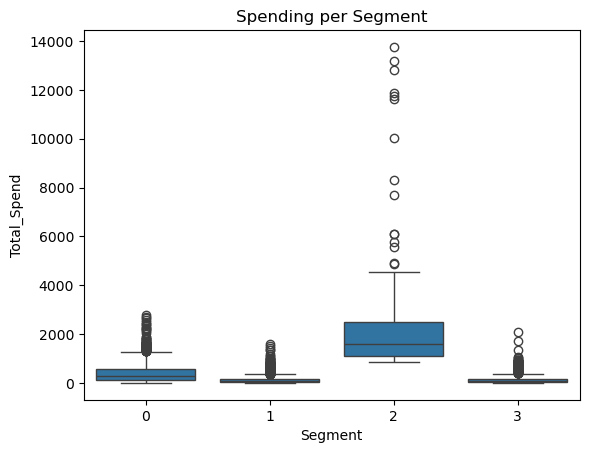

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=user_summary, x='Segment', y='Total_Spend')
plt.title("Spending per Segment")

plt.show()


In [67]:
segment_map = {
    2: 'High Spenders',
    0: 'Moderate',
    1: 'Low Spenders',
    3: 'Occasional'
}
user_summary['Segment_Label'] = user_summary['Segment'].map(segment_map)

<Axes: title={'center': 'Users per Segment'}, xlabel='Segment_Label'>

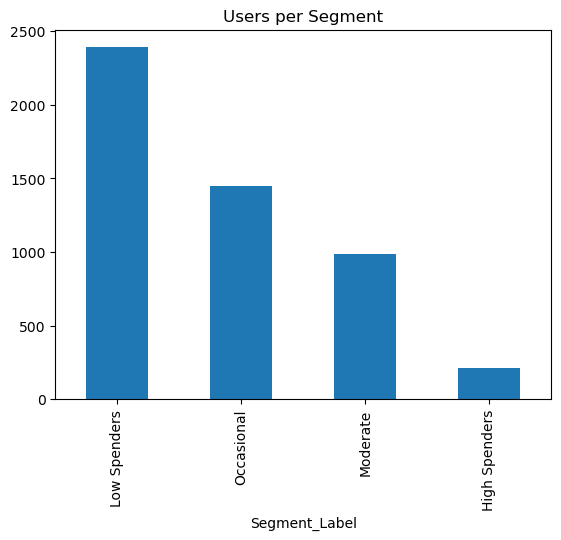

In [69]:
user_summary['Segment_Label'].value_counts().plot(kind='bar', title='Users per Segment')

<Axes: xlabel='Segment', ylabel='Recency_Days'>

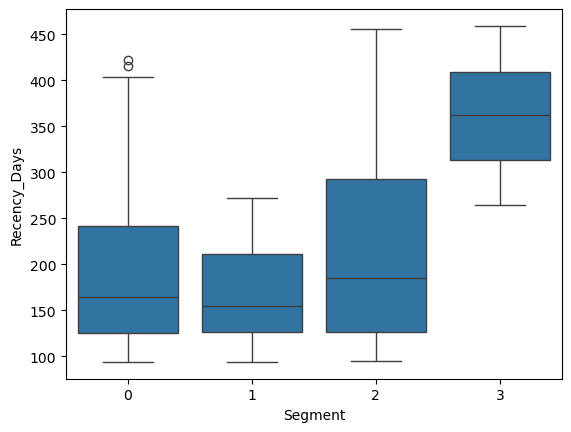

In [71]:
sns.boxplot(data=user_summary, x='Segment', y='Recency_Days')


In [73]:
user_summary.to_csv("user_summary_segmented.csv", index=False)

In [75]:
segment_profile = user_summary.groupby('Segment').agg({
    'Total_Spend': ['mean', 'median'],
    'Avg_Order_Value': 'mean',
    'Recency_Days': 'mean',
    'Orders_Per_Day': 'mean',
    'Age_first': 'mean',
    'Total_Orders': 'mean'
}).round(2)

display(segment_profile)

Total_Spend          Avg_Order_Value Recency_Days Orders_Per_Day  \
               mean   median            mean         mean           mean   
Segment                                                                    
0            438.82   274.52          138.05       188.86           0.10   
1            137.83    75.35          122.34       168.30           1.07   
2           2301.98  1591.81         1294.91       220.49           0.83   
3            145.64    76.62          128.21       361.91           1.03   

        Age_first Total_Orders  
             mean         mean  
Segment                         
0           27.76         3.29  
1           27.35         1.12  
2           26.16         2.60  
3           27.48         1.15

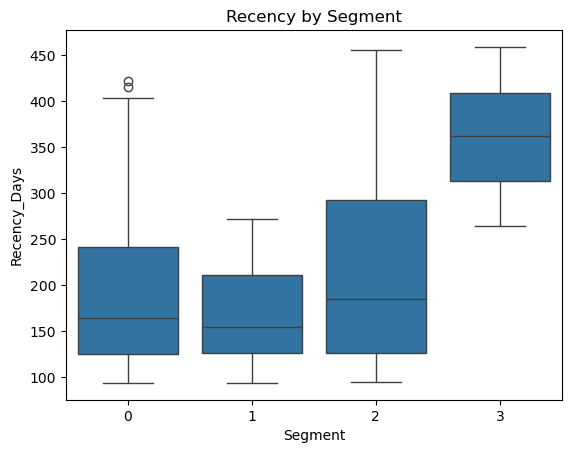

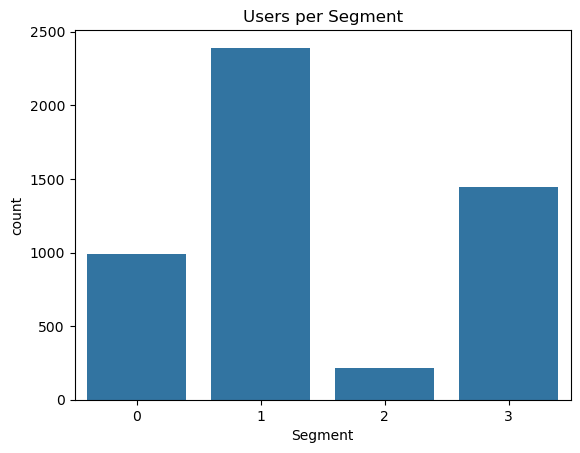

In [77]:
# Boxplot of Recency
sns.boxplot(data=user_summary, x='Segment', y='Recency_Days')
plt.title("Recency by Segment")
plt.show()

# Count of users per segment
sns.countplot(data=user_summary, x='Segment')
plt.title("Users per Segment")
plt.show()


In [83]:
user_summary['R'] = pd.cut(user_summary['Recency_Days'], bins=5, labels=[5, 4, 3, 2, 1])
user_summary['F'] = pd.cut(user_summary['Total_Orders'], bins=5, labels=[1, 2, 3, 4, 5])
user_summary['M'] = pd.cut(user_summary['Total_Spend'], bins=5, labels=[1, 2, 3, 4, 5])


In [85]:
user_summary.to_csv("Segmented_Customers.csv", index=False)